
# Lecture 5 — Transformers & Self-Attention (Theory + Practice)

本 Notebook 覆盖 Lec5（Transformer）的主要理论要点，并配套 PyTorch 代码实践，结构大致如下：

1. 从 RNN+Attention 到 Self-Attention 的动机  
2. Scaled Dot-Product Attention 与一般 Attention 公式  
3. Self-Attention 与 Multi-Head Attention（形状、复杂度、直觉）  
4. Positional Encoding（正弦位置编码）理论与实现  
5. Transformer Encoder / Decoder 结构：残差连接、LayerNorm、前馈网络、掩蔽注意力  
6. 手撸一个小型 Transformer Encoder 模块（PyTorch 实现）  
7. 用 Transformer Encoder 做一个玩具**序列分类**任务（和 Lec4 的 RNN 形成对照）  
8. 简单示例：使用 `nn.Transformer` 做序列到序列的玩具映射  

> 运行前请确认：环境中已安装 `torch`, `matplotlib`, `numpy`。


In [4]:

import math
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')


## 1. 从 RNN+Attention 到 Self-Attention 的动机

早期的序列到序列模型（seq2seq），如机器翻译，通常使用：

- **Encoder**：RNN（如 LSTM/GRU）编码源语言序列，得到一个固定长度的向量 $c$（上下文向量）。  
- **Decoder**：另一个 RNN，每一步都以 $c$ 和之前生成的词为条件，生成目标序列。

问题：
- 对长序列，**把整句压缩到一个向量 $c$**，信息易丢失。

### 1.1 RNN + Attention（对齐机制）

Attention 的想法：
- 不再只有一个全局上下文向量，而是在解码每一步 $t$ 时，为所有 encoder hidden states $h_1, \dots, h_{T_x}$ **重新计算一个加权和**：
  $$
  c_t = \sum_{i=1}^{T_x} \alpha_{t,i} h_i,
  $$
  其中权重 $\alpha_{t,i}$ 表示“解码第 $t$ 个词时，对输入第 $i$ 个词的注意力权重”。

一般 Attention 形式：
1. *Score* / *Energy* 函数：
   $$
   e_{t,i} = \text{score}(s_{t-1}, h_i)
   $$
   常见 score：dot、bilinear、MLP 等。
2. Softmax 归一化：
   $$
   \alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_{j} \exp(e_{t,j})}
   $$
3. 上下文向量：
   $$
   c_t = \sum_i \alpha_{t,i} h_i
   $$

**Self-Attention** 则是进一步的推广：
- 不区分 encoder/decoder 的 hidden state，而是让序列中的每个位置都可以对“所有位置”做注意力，得到上下文表示。



## 2. Scaled Dot-Product Attention

Transformer 中使用的 attention 核心是 **scaled dot-product attention**：

给定：
- Query 矩阵 $Q \in \mathbb{R}^{n_q \times d_k}$
- Key 矩阵 $K \in \mathbb{R}^{n_k \times d_k}$
- Value 矩阵 $V \in \mathbb{R}^{n_k \times d_v}$

定义：
$$
\text{Attention}(Q, K, V) = \text{softmax}\Big(\frac{Q K^\top}{\sqrt{d_k}}\Big) V
$$

- $QK^\top$ 给出所有 query 对所有 key 的相似度（点积）。  
- 除以 $\sqrt{d_k}$ 用来**缩放**，避免 $d_k$ 大时点积值过大，使 softmax 区分度过高。  
- softmax 后的矩阵即注意力权重矩阵 $A \in \mathbb{R}^{n_q \times n_k}$，每一行是对所有 key 的概率分布。  

Self-Attention 的特例：
- $Q = K = V = X W_Q, X W_K, X W_V$，其中 $X$ 是同一个序列的表示。



### 2.1 代码实现：Scaled Dot-Product Attention

In [5]:

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout_p: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, Q, K, V, mask=None):
        """
        Q: (batch, n_q, d_k)
        K: (batch, n_k, d_k)
        V: (batch, n_k, d_v)
        mask: (batch, 1, n_k) or (batch, n_q, n_k), positions with mask==1 will be ignored
        """
        d_k = Q.size(-1)
        # (batch, n_q, n_k)
        scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)

        if mask is not None:
            # mask == 1 positions set to -inf
            scores = scores.masked_fill(mask == 1, float("-inf"))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        # (batch, n_q, d_v)
        output = attn @ V
        return output, attn

# 简单随机测试一下形状
torch.manual_seed(0)
Q = torch.randn(2, 4, 8)  # batch=2, n_q=4, d_k=8
K = torch.randn(2, 5, 8)
V = torch.randn(2, 5, 16) # d_v=16
attn_layer = ScaledDotProductAttention()
out, attn_weights = attn_layer(Q, K, V)
print("out shape:", out.shape)          # (2, 4, 16)
print("attn_weights shape:", attn_weights.shape)  # (2, 4, 5)


out shape: torch.Size([2, 4, 16])
attn_weights shape: torch.Size([2, 4, 5])



## 3. Multi-Head Self-Attention

单头注意力：
- 先用线性变换得到 $Q, K, V$，再做一次 attention。

Multi-head 的做法：
- 使用 $h$ 个头，每个头都有不同的投影矩阵：
  $$
  Q_i = X W_i^Q,\quad K_i = X W_i^K,\quad V_i = X W_i^V,\quad i=1,\dots,h
  $$
- 每个头单独做 scaled dot-product attention：
  $$
  \text{head}_i = \text{Attention}(Q_i, K_i, V_i)
  $$
- 把所有头拼接起来，再做一次线性变换：
  $$
  \text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1,\dots,\text{head}_h) W^O
  $$

好处：
- 每个头在不同子空间上“看”数据，捕捉不同类型的相关性。
- 比单头更灵活、表达能力更强。



### 3.1 代码实现：Multi-Head Attention

先把 **Multi-Head Attention 的公式**摆出来，再一行行对照你这段代码讲。

---

## 1. 理论公式回顾：Multi-Head Attention

给定输入序列表示 $(X \in \mathbb{R}^{n \times d_{\text{model}}})$，

每一头 (i) 有自己的一组三个线性变换：

$$
[
Q_i = X W_i^Q,\quad
K_i = X W_i^K,\quad
V_i = X W_i^V
]
$$

单头的 **Scaled Dot-Product Attention**：
$$
[
\text{head}_i = \text{Attention}(Q_i, K_i, V_i)
= \text{softmax}\Big( \frac{Q_i K_i^\top}{\sqrt{d_k}} \Big) V_i
]
$$

Multi-head 把所有头拼起来，再过一个线性层：
$$
[
\text{MultiHead}(X) =
\text{Concat}(\text{head}_1,\dots,\text{head}_h) W^O
]
$$
其中：

* $h = \text{num_heads}$
* $d_k = d_{\text{model}} / h$（每头的维度）

你这段 `MultiHeadAttention` 正好就是上面这套东西的 PyTorch 实现。

---

## 2. 初始化部分：对应 (W_i^Q, W_i^K, W_i^V, W^O)

```python
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.0):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.attn = ScaledDotProductAttention(dropout_p)
        self.dropout = nn.Dropout(dropout_p)
```

* `d_model` = Transformer 里常说的 $d_{\text{model}}$。
* `num_heads` = $h$。
* `self.d_k = d_model // num_heads` = 每个头的 key/query 维度 $d_k$，满足 $d_{\text{model}} = h \cdot d_k$。

下面这几行是“打包版”的投影矩阵：

* `self.W_q: Linear(d_model, d_model)`
* `self.W_k: Linear(d_model, d_model)`
* `self.W_v: Linear(d_model, d_model)`

从数学上看，本来每个头应该有自己的 $W_i^Q \in \mathbb{R}^{d_{\text{model}} \times d_k}$ 等，但代码里是先把它们拼在一起得到一个大矩阵 $W^Q \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$，之后再用 reshape 把最后一维拆回 `(num_heads, d_k)`。

`self.out_proj` 对应 $W^O \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$。

`self.attn` 是实现单头的：

```python
Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
```

---

## 3. forward: 映射到 Q/K/V，再拆头

```python
def forward(self, x_q, x_kv, mask=None):
    """
    x_q: (batch, n_q, d_model)
    x_kv: (batch, n_k, d_model)
    mask: (batch, 1, 1, n_k) or (batch, 1, n_q, n_k)
    """
    batch_size = x_q.size(0)

    # 线性映射
    Q = self.W_q(x_q)  # (batch, n_q, d_model)
    K = self.W_k(x_kv) # (batch, n_k, d_model)
    V = self.W_v(x_kv) # (batch, n_k, d_model)
```

这里就是在做：

$$
[
Q = X_Q W^Q,\quad
K = X_{KV} W^K,\quad
V = X_{KV} W^V
]
$$

只不过：

* `x_q` 对应 query 的输入（比如 decoder 的 hidden states）
* `x_kv` 对应 key/value 的输入（比如 encoder 的输出，或者 self-attn 时就等于 `x_q`）

此时形状是：

* `Q`: `(B, n_q, d_model)`
* `K`: `(B, n_k, d_model)`
* `V`: `(B, n_k, d_model)`

接下来拆成多头：

```python
    # 拆成多头： (batch, num_heads, n_q, d_k)
    def split_heads(x):
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    Q = split_heads(Q)
    K = split_heads(K)
    V = split_heads(V)
```

`view(batch_size, -1, num_heads, d_k)` 把最后的 `d_model` 拆成 `(num_heads, d_k)`，然后 `.transpose(1, 2)` 把维度排列从 `(B, n, h, d_k)` 变成：

* `Q`: `(B, h, n_q, d_k)`
* `K`: `(B, h, n_k, d_k)`
* `V`: `(B, h, n_k, d_k)`

这一步在数学上等价于：

> 把大矩阵 (Q) 拆成 (h) 份，每一份是一个 head 的 (Q_i)。

此时每个 head 的张量就是 `Q[:, i, :, :]`（第 i 个头）。

---

## 4. 调用 Scaled Dot-Product Attention：对应公式

```python
    # 这里简单地把 mask 直接传给底层 attention, 假定 mask 已经 broadcast 好
    out, attn_weights = self.attn(Q, K, V, mask=mask)
    # out: (batch, num_heads, n_q, d_k)
```

`ScaledDotProductAttention` 里做的是：

```python
scores = Q @ K.transpose(-2, -1) / sqrt(d_k)
attn = softmax(scores, dim=-1)
output = attn @ V
```

对每个 head 来说，就是那句标准公式：

$$
[
\text{head}_i = \text{softmax}\Big( \frac{Q_i K_i^\top}{\sqrt{d_k}} \Big) V_i
]
$$

形状上：

* `Q`: `(B, h, n_q, d_k)`
* `K.transpose(-2,-1)`: `(B, h, d_k, n_k)`
* `Q @ K^T`: `(B, h, n_q, n_k)` → 每个 query 对每个 key 的匹配分数
* softmax 后 `attn`: `(B, h, n_q, n_k)`
* `attn @ V`: `(B, h, n_q, d_k)` → 每个 head 的输出

`attn_weights` 返回的就是 `(B, h, n_q, n_k)`，你测试时打印：

```python
out, attn_w = mha(x, x)
print("attn weights shape:", attn_w.shape)  # (2, 4, 5, 5)
```

解释这四个维度：

* `2`  = batch size
* `4`  = num_heads
* `5`  = n_q = 序列长度（每个 query 位置）
* `5`  = n_k = 序列长度（每个 key 位置）

所以 `attn_w[b, h, i, j]` 就是：**batch b、head h 的第 i 个 token 对第 j 个 token 的注意力权重**。

---

## 5. 合并多头 + 线性输出：对应 Concat 和 $W^O$

```python
    # 合并多头
    out = out.transpose(1, 2).contiguous()  # (batch, n_q, num_heads, d_k)
    out = out.view(batch_size, -1, self.d_model)  # (batch, n_q, d_model)

    out = self.out_proj(out)  # (batch, n_q, d_model)
    return out, attn_weights
```

这部分对应公式：

$$
[
\text{Concat}(\text{head}_1,\dots,\text{head}*h) \in \mathbb{R}^{n_q \times (h \cdot d_k)} = \mathbb{R}^{n_q \times d*{\text{model}}}
]
$$

* `out` 现在是 `(B, h, n_q, d_k)`
* `transpose(1,2)` → `(B, n_q, h, d_k)`
* `view(batch_size, -1, d_model)` → `(B, n_q, d_model)`，完成 head 的拼接

最后一行：

```python
out = self.out_proj(out)
```

就是乘上 $W^O$：
$$
[
Y = \text{Concat}(\text{head}_1,\dots,\text{head}_h) W^O
]
$$

输出 shape 保持 `(B, n_q, d_model)`，和输入 `x_q` 的特征维度一致，方便后面做残差连接：

```python
x = x + mha_out
```

---

## 6. 随机测试那几行在做什么？

```python
torch.manual_seed(0)
x = torch.randn(2, 5, 32)  # batch=2, seq_len=5, d_model=32
mha = MultiHeadAttention(d_model=32, num_heads=4)
out, attn_w = mha(x, x)
print("out shape:", out.shape)          # (2, 5, 32)
print("attn weights shape:", attn_w.shape)  # (2, 4, 5, 5)
```

* `x` 是一个长度为 5 的序列，每个 token 的维度 32。
* `MultiHeadAttention(32, 4)` → `d_k = 8`。
* 自注意力：`x_q = x_kv = x`。

期望：

* 输出 `out` 的 shape 还是 `(B, L, d_model) = (2,5,32)`。
* 注意力权重 `attn_w` shape 是 `(B, h, L, L) = (2,4,5,5)`。

和理论完全对得上。

---

## 7. 关于 mask 的一点补充

在你的实现里 `mask` 直接传到 `ScaledDotProductAttention`，它会做：

```python
scores = scores.masked_fill(mask == 1, -inf)
```

理论上这里 `mask` 应该是能 broadcast 成 `scores` 的形状 `(B, h, n_q, n_k)` 的布尔/0-1 tensor，例如：

* Encoder self-attn (padding mask)：`mask: (B, 1, 1, n_k)`
* Decoder masked self-attn：`mask: (B, 1, n_q, n_k)`，结合 “未来位置上三角” 和 padding mask

你的注释写的是：

```python
mask: (batch, 1, 1, n_k) or (batch, 1, n_q, n_k)
```

这在广播到 `(B, h, n_q, n_k)` 时是合理的，只要外面构造的时候注意一下就行。

---

如果你想，我可以在这个基础上再帮你**画一个详细的维度流图**（Q/K/V 到 scores 到 attn 到 head 合并）或者写一个极简的 numpy 版本，让你在 PPT 上更直观展示每步对应的矩阵乘法。


In [6]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.0):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.attn = ScaledDotProductAttention(dropout_p)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x_q, x_kv, mask=None):
        """
        x_q: (batch, n_q, d_model)
        x_kv: (batch, n_k, d_model)
        mask: (batch, 1, 1, n_k) or (batch, 1, n_q, n_k)
        """
        batch_size = x_q.size(0)

        # 线性映射
        Q = self.W_q(x_q)  # (batch, n_q, d_model)
        K = self.W_k(x_kv) # (batch, n_k, d_model)
        V = self.W_v(x_kv) # (batch, n_k, d_model)

        # 拆成多头： (batch, num_heads, n_q, d_k)
        def split_heads(x):
            return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        Q = split_heads(Q)
        K = split_heads(K)
        V = split_heads(V)

        # 这里简单地把 mask 直接传给底层 attention, 假定 mask 已经 broadcast 好
        out, attn_weights = self.attn(Q, K, V, mask=mask)
        # out: (batch, num_heads, n_q, d_k)

        # 合并多头
        out = out.transpose(1, 2).contiguous()  # (batch, n_q, num_heads, d_k)
        out = out.view(batch_size, -1, self.d_model)  # (batch, n_q, d_model)

        out = self.out_proj(out)  # (batch, n_q, d_model)
        return out, attn_weights

# 简单随机测试形状
torch.manual_seed(0)
x = torch.randn(2, 5, 32)  # batch=2, seq_len=5, d_model=32
mha = MultiHeadAttention(d_model=32, num_heads=4)
out, attn_w = mha(x, x)
print("out shape:", out.shape)          # (2, 5, 32)
print("attn weights shape:", attn_w.shape)  # (2, 4, 5, 5)


out shape: torch.Size([2, 5, 32])
attn weights shape: torch.Size([2, 4, 5, 5])



## 4. Positional Encoding（位置编码）

Self-Attention 本身**不包含位置信息**：对序列做任意置换，注意力的机制（不含额外信息时）看不到谁在前、谁在后。

因此 Transformer 需要显式把“位置”编码进输入中。Lec5 中使用的是 **正弦位置编码（Sinusoidal Positional Encoding）**：

对位置 $t$ 和维度索引 $2i, 2i+1$：

$$
\text{PE}_{(t, 2i)} = \sin\Big(\frac{t}{10000^{2i/d_{\text{model}}}}\Big),\quad
\text{PE}_{(t, 2i+1)} = \cos\Big(\frac{t}{10000^{2i/d_{\text{model}}}}\Big)
$$

性质：
- 对每个位置得到一个**唯一**的编码。  
- 不同句子长度下，相对距离保持一致。  
- 可以外推到更长的序列，无需额外学习参数。  
- 值有界于 [-1,1]，数值稳定。



### 4.1 代码实现：Sinusoidal Positional Encoding

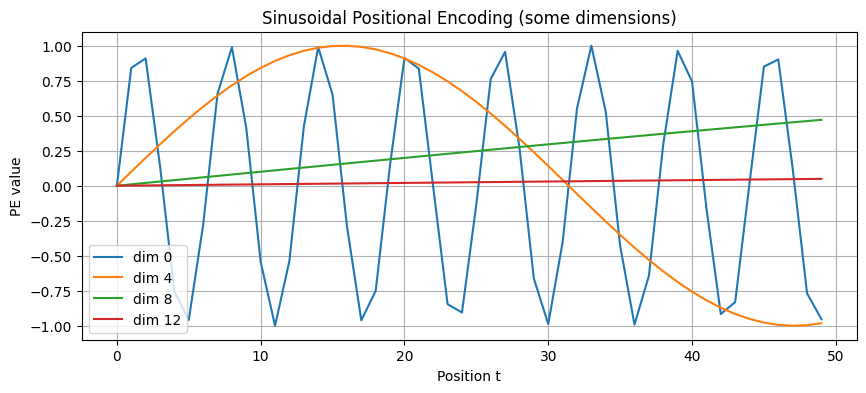

In [7]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout_p: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """x: (batch, seq_len, d_model)"""
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

# 可视化部分维度的位置编码
d_model = 16
max_len = 50
pe_layer = PositionalEncoding(d_model=d_model, max_len=max_len)
pe_vals = pe_layer.pe[0, :max_len, :].detach().numpy()

plt.figure(figsize=(10, 4))
for i in range(0, d_model, 4):
    plt.plot(pe_vals[:, i], label=f"dim {i}")
plt.legend()
plt.title("Sinusoidal Positional Encoding (some dimensions)")
plt.xlabel("Position t")
plt.ylabel("PE value")
plt.grid(True)
plt.show()



## 5. Transformer Encoder / Decoder 结构

### 5.1 Encoder Block

一个标准的 Transformer Encoder Layer 通常包含：

1. **Multi-Head Self-Attention + 残差连接 + LayerNorm**
   $$
   \tilde X = \text{LayerNorm}(X + \text{MultiHeadSelfAttn}(X))
   $$
2. **Position-wise FeedForward + 残差连接 + LayerNorm**
   $$
   Y = \text{LayerNorm}(\tilde X + \text{FFN}(\tilde X))
   $$

其中 FFN 一般是两层 MLP：
$$
\text{FFN}(x) = \max(0, x W_1 + b_1) W_2 + b_2
$$

**残差连接 (Residual Connection)** 的作用（Lec5）：

1. 为反向传播提供更好的梯度通路，缓解梯度消失。  
2. 让信息在层间**更本地**地保留，即使注意力改变了 token 的上下文表示，仍保留一部分原始输入。  

**Layer Normalization**：对每个样本在特征维度上做归一化，稳定训练。

### 5.2 Decoder Block（简要）

Decoder 多了两类注意力：

1. **Masked Self-Attention**：
   - 解码时只能看见**当前位置之前**的 token，不能“偷看未来”。
   - 通过在 attention scores 上对未来位置加 `-inf` 来实现 mask。

2. **Encoder-Decoder Cross-Attention**：
   - Query 来自 decoder 的 hidden states；
   - Key/Value 来自 encoder 的输出。
   - 让解码每个位置可以“对齐”到源序列的不同位置。



### 5.3 代码实现：一个简化的 Transformer Encoder Layer

In [8]:

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout_p: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout_p: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout_p)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout_p)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_p)
        self.dropout2 = nn.Dropout(dropout_p)

    def forward(self, x, src_mask=None):
        # Self-attention + 残差 + LN
        attn_out, attn_weights = self.self_attn(x, x, mask=src_mask)
        x = x + self.dropout1(attn_out)
        x = self.norm1(x)

        # FFN + 残差 + LN
        ffn_out = self.ffn(x)
        x = x + self.dropout2(ffn_out)
        x = self.norm2(x)

        return x, attn_weights

# 简单测试形状
torch.manual_seed(0)
encoder_layer = TransformerEncoderLayer(d_model=32, num_heads=4, d_ff=64)
test_x = torch.randn(2, 10, 32)  # (batch, seq_len, d_model)
out, attn_w = encoder_layer(test_x)
print("Encoder layer out shape:", out.shape)
print("Attention weights shape:", attn_w.shape)


Encoder layer out shape: torch.Size([2, 10, 32])
Attention weights shape: torch.Size([2, 4, 10, 10])



## 6. 用 Transformer Encoder 做玩具序列分类任务

为了直观理解 Transformer Encoder 的使用，我们构造一个简单任务：

- 输入：长度为 `seq_len` 的整数序列，每个元素在 \([1, V)\) 之间。  
- 标签：这条序列中元素的**和是否大于某个阈值**（二分类问题）。

这要求模型：
- 对整段序列进行“全局聚合”；  
- Transformer 可以利用 self-attention 直接把远距离位置信息相互融合，得到全局表示。  


In [9]:

def generate_sum_threshold_dataset(num_samples=5000, seq_len=10, vocab_size=20, threshold=90):
    """
    生成序列和阈值分类数据集:
    - 每个 token ~ Uniform[1, vocab_size)
    - label = 1 if sum(x) > threshold else 0
    """
    X = torch.randint(1, vocab_size, (num_samples, seq_len))
    sums = X.sum(dim=1)
    y = (sums > threshold).long()
    return X, y, sums

seq_len = 10
vocab_size = 30
num_samples = 6000
threshold = 120

X, y, sums = generate_sum_threshold_dataset(num_samples, seq_len, vocab_size, threshold)
print("Example sequence:", X[0])
print("Sum:", sums[0].item(), "Label:", y[0].item())

# Train / Val / Test 划分
n_train = int(0.7 * num_samples)
n_val = int(0.15 * num_samples)
n_test = num_samples - n_train - n_val

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

len(train_ds), len(val_ds), len(test_ds)


Example sequence: tensor([13, 27, 17,  8, 29, 24, 10, 27, 19, 29])
Sum: 203 Label: 1


(4200, 900, 900)


### 6.1 定义 Transformer Encoder 分类模型

结构：  
- Embedding (token embedding) + PositionalEncoding  
- 若干个 EncoderLayer 堆叠  
- 对最后的序列表示做平均池化 / 取 `[CLS]` 位置，再接一个线性层输出分类结果。  


In [10]:

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, d_ff, dropout_p=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout_p)
            for _ in range(num_layers)
        ])

    def forward(self, x, src_mask=None):
        attn_weights_all = []
        for layer in self.layers:
            x, attn_weights = layer(x, src_mask=src_mask)
            attn_weights_all.append(attn_weights)
        return x, attn_weights_all

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_layers=2, num_heads=4, d_ff=128, max_len=100, num_classes=2, dropout_p=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=max_len, dropout_p=dropout_p)
        self.encoder = TransformerEncoder(d_model, num_layers, num_heads, d_ff, dropout_p)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, src_mask=None):
        """x: (batch, seq_len), int indices"""
        x = self.token_emb(x)  # (batch, seq_len, d_model)
        x = self.pos_encoding(x)
        enc_out, attn_weights_all = self.encoder(x, src_mask=src_mask)
        # 简单地对序列做平均池化
        pooled = enc_out.mean(dim=1)  # (batch, d_model)
        logits = self.classifier(pooled)
        return logits, attn_weights_all

model = TransformerClassifier(vocab_size=vocab_size, d_model=64, num_layers=2, num_heads=4, d_ff=128, max_len=seq_len)
model.to(device)
model


TransformerClassifier(
  (token_emb): Embedding(30, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (out_proj): Linear(in_features=64, out_features=64, bias=True)
          (attn): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=64, out_features=128, bias=True)
          (linear2): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm1): Lay

In [11]:

def evaluate_classifier(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = loss_fn(logits, y)
            preds = logits.argmax(dim=1)
            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_acc += (preds == y).float().sum().item()
            total_samples += batch_size
    return total_loss / total_samples, total_acc / total_samples

def train_transformer_classifier(model, train_loader, val_loader, epochs=15, lr=1e-3):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, val_accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = x.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
        train_loss = total_loss / total_samples
        val_loss, val_acc = evaluate_classifier(model, val_loader, loss_fn, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"[Transformer] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")
    return train_losses, val_losses, val_accs

train_losses_tr, val_losses_tr, val_accs_tr = train_transformer_classifier(model, train_loader, val_loader, epochs=15, lr=1e-3)


[Transformer] Epoch 1: train_loss=0.2899, val_loss=0.1148, val_acc=95.67%
[Transformer] Epoch 2: train_loss=0.1113, val_loss=0.1223, val_acc=94.78%
[Transformer] Epoch 3: train_loss=0.0925, val_loss=0.0581, val_acc=97.67%
[Transformer] Epoch 4: train_loss=0.0779, val_loss=0.1079, val_acc=94.89%
[Transformer] Epoch 5: train_loss=0.0639, val_loss=0.0448, val_acc=98.33%
[Transformer] Epoch 6: train_loss=0.0594, val_loss=0.0580, val_acc=97.56%
[Transformer] Epoch 7: train_loss=0.0545, val_loss=0.0645, val_acc=97.89%
[Transformer] Epoch 8: train_loss=0.0528, val_loss=0.0574, val_acc=96.89%
[Transformer] Epoch 9: train_loss=0.0453, val_loss=0.0636, val_acc=96.89%
[Transformer] Epoch 10: train_loss=0.0406, val_loss=0.0507, val_acc=97.78%
[Transformer] Epoch 11: train_loss=0.0366, val_loss=0.0614, val_acc=97.56%
[Transformer] Epoch 12: train_loss=0.0453, val_loss=0.0569, val_acc=97.67%
[Transformer] Epoch 13: train_loss=0.0349, val_loss=0.0631, val_acc=96.67%
[Transformer] Epoch 14: train_loss

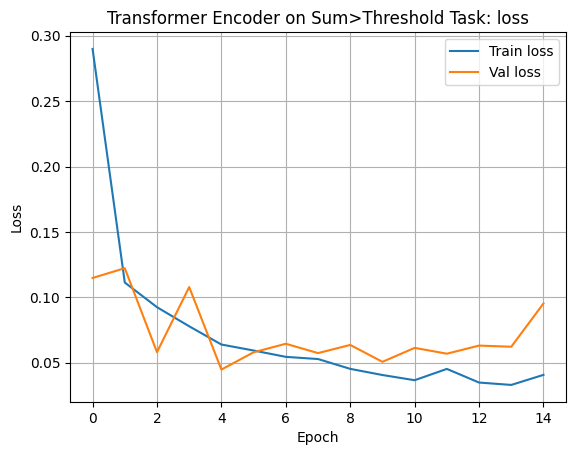

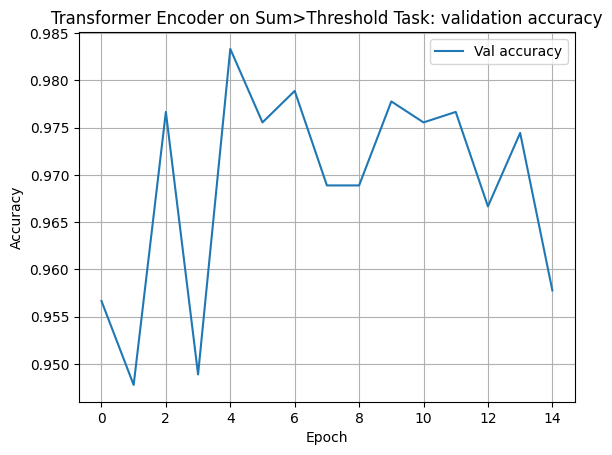

Test loss: 0.0947, Test accuracy: 95.89%


In [12]:

plt.figure()
plt.plot(train_losses_tr, label="Train loss")
plt.plot(val_losses_tr, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transformer Encoder on Sum>Threshold Task: loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_accs_tr, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Transformer Encoder on Sum>Threshold Task: validation accuracy")
plt.legend()
plt.grid(True)
plt.show()

loss_fn = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate_classifier(model, test_loader, loss_fn, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc*100:.2f}%")



### 6.2 可视化一条序列上的注意力权重

我们从测试集中取一条样本，看第一层第一个 head 的 self-attention 矩阵。

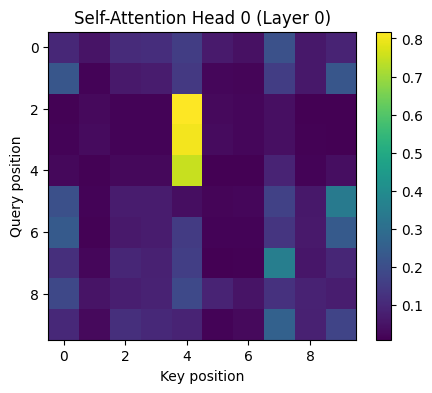

Sequence: [27, 13, 10, 10, 29, 4, 13, 2, 23, 14]
True label: 1 Pred: 1


In [13]:

model.eval()
x_example, y_example = next(iter(test_loader))
x_example = x_example[:1].to(device)  # 取一条
y_example = y_example[0].item()
with torch.no_grad():
    logits, attn_weights_all = model(x_example)
    pred_label = logits.argmax(dim=1).item()

attn_first_layer = attn_weights_all[0]  # (batch=1, num_heads, seq_len, seq_len)
attn_first_layer = attn_first_layer[0].cpu().numpy()  # (num_heads, seq_len, seq_len)

head_id = 0
attn_matrix = attn_first_layer[head_id]

plt.figure(figsize=(5, 4))
plt.imshow(attn_matrix, cmap="viridis")
plt.colorbar()
plt.xlabel("Key position")
plt.ylabel("Query position")
plt.title(f"Self-Attention Head {head_id} (Layer 0)")
plt.show()

print("Sequence:", x_example[0].cpu().tolist())
print("True label:", y_example, "Pred:", pred_label)



## 7. 简单示例：使用 `nn.Transformer` 做玩具 Seq2Seq 映射

PyTorch 内置了 `nn.Transformer` 模块，实现了完整的 Encoder-Decoder 结构：  
- 包含多层 Encoder / Decoder；  
- 自动处理多头注意力、残差、LayerNorm、前馈网络。  

这里做一个极简玩具任务：
- 输入序列为长度 `L` 的整数序列 \((x_1, ..., x_L)\)；
- 目标序列为每个元素加 1（模 `vocab_size`）：\((x_1+1, ..., x_L+1)\)。

我们用 `nn.Transformer` 学习这个映射，主要关注：
- src / tgt 的 **mask 构造**；  
- forward 接口使用。


In [14]:

class ToySeq2SeqDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=2000, seq_len=6, vocab_size=20):
        super().__init__()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.src = torch.randint(1, vocab_size, (num_samples, seq_len))
        self.tgt = (self.src + 1) % vocab_size
        self.tgt[self.tgt == 0] = 1  # 保证不为 0

    def __len__(self):
        return self.src.size(0)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

def generate_square_subsequent_mask(size):
    # 下三角 mask: 允许看到之前和当前的位置，禁止看到未来
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask == 1  # True 表示被 mask

toy_dataset = ToySeq2SeqDataset(num_samples=3000, seq_len=6, vocab_size=20)
train_size = int(0.8 * len(toy_dataset))
val_size = len(toy_dataset) - train_size
toy_train, toy_val = torch.utils.data.random_split(toy_dataset, [train_size, val_size])

toy_train_loader = DataLoader(toy_train, batch_size=64, shuffle=True)
toy_val_loader = DataLoader(toy_val, batch_size=64)

len(toy_train), len(toy_val)


(2400, 600)

In [15]:

class ToyTransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size=20, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, seq_len=6):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.seq_len = seq_len

        self.src_emb = nn.Embedding(vocab_size, d_model)
        self.tgt_emb = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=seq_len)

        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=nhead,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          dim_feedforward=dim_feedforward,
                                          batch_first=True)
        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt_in):
        """
        src: (batch, src_len)
        tgt_in: (batch, tgt_len) -- decoder 输入（通常是 <bos> + 右移一位的目标序列）
        """
        src_emb = self.pos_encoding(self.src_emb(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_encoding(self.tgt_emb(tgt_in) * math.sqrt(self.d_model))

        src_mask = None
        tgt_mask = generate_square_subsequent_mask(tgt_in.size(1)).to(src.device)

        memory = self.transformer.encoder(src_emb, mask=src_mask)
        out = self.transformer.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
        logits = self.output_proj(out)
        return logits

toy_model = ToyTransformerSeq2Seq(vocab_size=20, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, seq_len=6).to(device)
toy_model


ToyTransformerSeq2Seq(
  (src_emb): Embedding(20, 64)
  (tgt_emb): Embedding(20, 64)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )


In [16]:

def train_toy_transformer(model, train_loader, val_loader, epochs=10, lr=1e-3):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_tokens = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            # decoder 输入：把 tgt 右移一位，用第一个 token 直接用 tgt[:,0]（这里简化，不额外引入 <bos>）
            tgt_in = torch.roll(tgt, shifts=1, dims=1)
            # 简单起见，把第一个位置设为一个固定 token（例如 1）
            tgt_in[:, 0] = 1

            logits = toy_model(src, tgt_in)  # (batch, seq_len, vocab_size)
            loss = loss_fn(logits.view(-1, model.vocab_size), tgt.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * tgt.numel()
            total_tokens += tgt.numel()

        train_loss = total_loss / total_tokens

        # 验证集
        model.eval()
        val_loss = 0.0
        val_tokens = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                tgt_in = torch.roll(tgt, shifts=1, dims=1)
                tgt_in[:, 0] = 1
                logits = toy_model(src, tgt_in)
                loss = loss_fn(logits.view(-1, model.vocab_size), tgt.view(-1))
                val_loss += loss.item() * tgt.numel()
                val_tokens += tgt.numel()
        val_loss /= val_tokens
        print(f"[Toy Transformer] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

train_toy_transformer(toy_model, toy_train_loader, toy_val_loader, epochs=8, lr=1e-3)


[Toy Transformer] Epoch 1: train_loss=2.6016, val_loss=2.1584
[Toy Transformer] Epoch 2: train_loss=2.0581, val_loss=1.7832
[Toy Transformer] Epoch 3: train_loss=1.7960, val_loss=1.5799
[Toy Transformer] Epoch 4: train_loss=1.6523, val_loss=1.5071
[Toy Transformer] Epoch 5: train_loss=1.5669, val_loss=1.4204
[Toy Transformer] Epoch 6: train_loss=1.4927, val_loss=1.3805
[Toy Transformer] Epoch 7: train_loss=1.4359, val_loss=1.3315
[Toy Transformer] Epoch 8: train_loss=1.3794, val_loss=1.2701


In [17]:

# 测试：给定 src，让模型自回归生成预测（贪婪解码）
toy_model.eval()
src_example, tgt_example = toy_dataset[0]
src_example = src_example.unsqueeze(0).to(device)
tgt_example = tgt_example.unsqueeze(0).to(device)

# 初始 decoder 输入
generated = torch.full_like(tgt_example, fill_value=1)  # 全 1 占位
for t in range(generated.size(1)):
    logits = toy_model(src_example, generated)
    # 只取当前步的输出
    step_logits = logits[:, t, :]  # (1, vocab_size)
    step_pred = step_logits.argmax(dim=-1)
    generated[:, t] = step_pred

print("SRC:", toy_dataset[0][0].tolist())
print("True TGT:", toy_dataset[0][1].tolist())
print("Predicted TGT:", generated[0].cpu().tolist())


SRC: [19, 18, 12, 10, 5, 10]
True TGT: [1, 19, 13, 11, 6, 11]
Predicted TGT: [11, 13, 6, 19, 11, 19]



## 8. 总结 & 下一步可以做什么

本 Notebook 将 Lec5 的 Transformer 主要内容转换为：

1. **Attention 理论**
   - 从 RNN+attention 的对齐机制讲到 Scaled Dot-Product Attention。  
   - 理解 Q/K/V 的含义与矩阵形式。  

2. **Self-Attention & Multi-Head**
   - 形状变化（batch, seq_len, d_model）→ 多头拆分 → 再合并。  
   - 多头在不同子空间里“并行关注”不同模式。  

3. **Positional Encoding**
   - 正弦位置编码的公式与性质。  
   - 为什么 self-attention 本身没有顺序信息，需要位置编码。  

4. **Transformer Encoder 结构**
   - Multi-Head Self-Attn + Residual + LayerNorm。  
   - Position-wise FFN + Residual + LayerNorm。  
   - 简单解释 Decoder 中的 Masked Self-Attn 与 Cross-Attn。  

5. **代码实践**
   - 手写 Scaled Dot-Product Attention、Multi-Head Attention、Positional Encoding。  
   - 搭建简化版 Transformer Encoder 层，并在玩具“序列和阈值”任务上做分类实验。  
   - 可视化注意力权重矩阵，直观看到“谁在关注谁”。  
   - 使用内置 `nn.Transformer` 实现一个极简 seq2seq 映射（元素+1），演示 mask 与 Encoder-Decoder 用法。  

---

你可以在此基础上进一步：
- 把玩具任务换成字符级/单词级语言建模或小词表翻译任务；  
- 对比 RNN vs Transformer 在相同玩具任务上的学习速度和表现；  
- 添加 Label Smoothing、Warmup 学习率调度等 Lec5 中提到的训练技巧；  
- 实现一个 mini-BERT 风格的 Encoder-only 预训练（如 Masked Language Modeling 的小 demo）。
